In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import levene
from scipy.stats import spearmanr
import scipy.stats as stats

# Data Preparation

In [2]:
df_prim = pd.read_csv('dataset/cleandata_time_ok.csv', delimiter = ',')
print(df_prim.shape)
display(df_prim.head(2))
display(df_prim.info())
display(df_prim.describe())
df_prim['Date-Time'] = pd.to_datetime(df_prim['Date-Time'])
df_prim.set_index('Date-Time', inplace = True)

(3491308, 12)


,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
0,2021-01-04T09:30:01.673284287,Quote,NaN,NaN,19.0,24.0,19.07,6.0,NaN,2021-01-04,NaN,09:30:01.673284
1,2021-01-04T09:30:01.673284287,Quote,NaN,NaN,19.0,24.0,19.01,6.0,NaN,2021-01-04,NaN,09:30:01.673284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3491308 entries, 0 to 3491307
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Date-Time           object 
 1   Type                object 
 2   Price               float64
 3   Volume              float64
 4   Bid Price           float64
 5   Bid Size            float64
 6   Ask Price           float64
 7   Ask Size            float64
 8   Tick Dir.           object 
 9   Date                object 
 10  num_tick_direction  float64
 11  Exchange_Time_copy  object 
dtypes: float64(7), object(5)
memory usage: 319.6+ MB


None

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction
count,1.377859e+06,1.377859e+06,3.491308e+06,3.491308e+06,3.491308e+06,3.491308e+06,377339.000000
mean,1.872580e+02,9.021554e+01,1.357627e+02,6.963457e+00,1.368762e+02,7.322325e+00,-0.000623
std,1.288883e+02,1.996205e+03,1.228293e+02,4.908565e+01,1.240740e+02,4.234311e+01,1.000001
min,1.710000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000
25%,6.625000e+01,5.000000e+00,3.891000e+01,1.000000e+00,3.903000e+01,1.000000e+00,-1.000000
50%,1.380100e+02,2.500000e+01,7.803000e+01,1.000000e+00,7.850000e+01,1.000000e+00,-1.000000
75%,3.188700e+02,1.000000e+02,2.593300e+02,3.000000e+00,2.630000e+02,3.000000e+00,1.000000
max,4.830000e+02,1.749449e+06,4.808600e+02,4.077000e+03,4.831700e+02,4.143000e+03,1.000000


## Trade Filter and To_Datetime

In [3]:
# Trade is for without resampling, to give insight on the overall period
trade = df_prim[df_prim['Type'] == 'Trade'].copy(deep = True)

# Trade_2 is the one for resampling 5-sec intervals 
trade_2 = df_prim[df_prim['Type'] == 'Trade'].copy(deep = True)

display(trade.shape)
display(trade_2.shape)

# Ensure date-time series
print(type(trade.index[0]))
print(type(trade_2.index[0]))

(1377859, 11)

(1377859, 11)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
trade.info()
trade_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:59:59.984096412
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Type                1377859 non-null  object 
 1   Price               1377859 non-null  float64
 2   Volume              1377859 non-null  float64
 3   Bid Price           1377859 non-null  float64
 4   Bid Size            1377859 non-null  float64
 5   Ask Price           1377859 non-null  float64
 6   Ask Size            1377859 non-null  float64
 7   Tick Dir.           377339 non-null   object 
 8   Date                1377859 non-null  object 
 9   num_tick_direction  377339 non-null   float64
 10  Exchange_Time_copy  1377859 non-null  object 
dtypes: float64(7), object(4)
memory usage: 126.1+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:

In [5]:
# Showing that there are duplicate indices on the original (not resampled) df
# So, mqr_prc_c and simple_pi_spread can only work on the resampled dataset 
# --> to resolve the issue of calling num_tick_dir from the dataset with duplicate indices
trade[trade.index.duplicated()]

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
Date-Time,,,,,,,,,,,
2021-01-04 09:30:04.792279959,Trade,19.06,100.0,19.0,22.0,19.06,1.0,^,2021-01-04,1.0,09:30:04.792279
2021-01-04 09:30:16.897319354,Trade,19.05,100.0,19.0,23.0,19.11,76.0,v,2021-01-04,-1.0,09:30:16.897319
2021-01-04 09:30:16.897319354,Trade,19.04,200.0,19.0,23.0,19.10,1.0,v,2021-01-04,-1.0,09:30:16.897319
2021-01-04 09:30:16.897319354,Trade,19.01,8.0,19.0,23.0,19.10,1.0,NaN,2021-01-04,NaN,09:30:16.897319
2021-01-04 09:31:46.784979556,Trade,19.03,100.0,19.0,13.0,19.03,1.0,v,2021-01-04,-1.0,09:31:46.784979
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:59.732302040,Trade,328.47,4.0,328.0,24.0,328.48,2.0,NaN,2021-01-29,NaN,15:59:59.732302
2021-01-29 15:59:59.780105211,Trade,328.48,20.0,328.0,24.0,328.48,2.0,NaN,2021-01-29,NaN,15:59:59.780105
2021-01-29 15:59:59.831869303,Trade,328.00,1.0,328.0,24.0,328.48,2.0,NaN,2021-01-29,NaN,15:59:59.831869


## Descriptive Statistics

In [6]:
descriptive = trade.describe()
descriptive.to_csv('charts_csv_report/descriptive.csv')

In [7]:
# Max Return based on Trading Price
max_ret = np.round((max(trade['Price'] - min(trade['Price'])))/(min(trade['Price'])) * 100, 2)
print(f'Maximum return during January 2021: {max_ret}%.')

Maximum return during January 2021: 2724.56%.


# Functions

## Trade Category and Cumulative Price Change

In [8]:
def trade_cat(df):
    
    '''
    This is my interpretation of the result, modified by introducing Micro group.
    Input: dataframe variable name
    Output: dataframe with additional columns related to Trade Category L1 and L2 and Price Change
    '''
    
    # Trade Categories based on Literature

    # Calculate Volume Classifier L1
    df.loc[(df['Volume'] <= 199), 'Trade_Size_L1'] = 'Micro'
    df.loc[(df['Volume'] > 199) & (df['Volume'] <= 499), 'Trade_Size_L1'] = 'Small'
    df.loc[(df['Volume'] > 499) & (df['Volume'] <= 9999), 'Trade_Size_L1'] = 'Medium'
    df.loc[(df['Volume'] > 9999), 'Trade_Size_L1'] = 'Large'

    # Calculate Volume Classifier L2
    df.loc[df['Volume'] <= 199, 'Trade_Size_L2'] = '<200'
    df.loc[(df['Volume'] > 199 ) & (df['Volume'] <= 299), 'Trade_Size_L2'] = '200-299'
    df.loc[(df['Volume'] > 299 ) & (df['Volume'] <= 399), 'Trade_Size_L2'] = '300-399'
    df.loc[(df['Volume'] > 399 ) & (df['Volume'] <= 499), 'Trade_Size_L2'] = '400-499'
    df.loc[(df['Volume'] > 499) & (df['Volume'] <= 999), 'Trade_Size_L2'] = '500-999'
    df.loc[(df['Volume'] > 999) & (df['Volume'] <= 2999), 'Trade_Size_L2'] = '1000-2999'
    df.loc[(df['Volume'] > 2999) & (df['Volume'] <= 5999), 'Trade_Size_L2'] = '3000-5999'
    df.loc[(df['Volume'] > 5999) & (df['Volume'] <= 9999), 'Trade_Size_L2'] = '6000-9999'
    df.loc[(df['Volume'] > 9999), 'Trade_Size_L2'] = '10000+'
    
    # Previous price
    df['Prev_Price'] = df['Price'].shift(periods = 1).fillna(0)
    
    # Price Change
    df['Price_Change'] = (df['Price'] - df['Prev_Price']).fillna(0)
    df.loc[(df.index == min(df.index)), 'Price_Change'] = 0 # --> 1st row price change is always 0
    
    # Price Change -- Abs Value 
    df['Price_Change_Abs'] = np.abs(df['Price_Change'])
    
    return df

## Cumulative Price Pivot

In [9]:
def piv_cumprice(df):
    '''
    Create pivot table as per stealth-trading journals
    Input: dataframe variable name
    Output: pivot table summary
    '''
    # Create Pivot Table

    piv_cumprice = pd.pivot_table(df, index = ['Trade_Size_L1', 'Trade_Size_L2'],
                                 values = ['Price_Change', 'Price','Volume'], 
                                  aggfunc = {'Price_Change':np.sum,'Price':'count','Volume': np.sum}, margins = False)

    
    piv_cumprice['% Price_Change'] = np.round((piv_cumprice['Price_Change']/piv_cumprice['Price_Change'].sum())*100, 2)
    piv_cumprice['% Trade'] = np.round((piv_cumprice['Price']/piv_cumprice['Price'].sum())*100, 2)
    piv_cumprice['% Volume'] = np.round((piv_cumprice['Volume']/piv_cumprice['Volume'].sum())*100, 2)

    piv_cumprice = piv_cumprice.rename(columns = {'Price':'# of Trade'})

    # Final Pivot Table with sum
    piv_cumprice = pd.pivot_table(piv_cumprice, index = ['Trade_Size_L1', 'Trade_Size_L2'], 
                                  aggfunc = 'sum', margins = 'all')


    

    # Sort index S-M-L
    piv_cumprice = piv_cumprice.sort_index(level = [0, 1], ascending = [False, True]) 
    
    new_order = ['Price_Change', '% Price_Change',
                 '# of Trade', '% Trade', 'Volume', '% Volume']

    piv_cumprice = piv_cumprice.reindex(columns = new_order)

    display(piv_cumprice)
    return piv_cumprice
    

## Mid-quote Return

In [10]:
def mqr_prc_c(df):
    '''
    Calculate Mid-quote return.
    Input: dataframe variable name
    Output: dataframe with additional columns related to mid-quote returns
    '''
    # Mid-Quote 
    df['Mid_Quote'] = (df['Bid Price'] + df['Ask Price'])/2
    
    # Previous mid-quote
    df['Prev_Mid_Quote'] = df['Mid_Quote'].shift(periods = 1).fillna(0)
    
    # Next mid-quote
    df['Next_Mid_Quote'] = df['Mid_Quote'].shift(periods = -1).fillna(0)
    
    # Mid-Quote Return
    df['Mid_Quote_Return'] = ((df['Mid_Quote'] - df['Prev_Mid_Quote'])/df['Prev_Mid_Quote']).fillna(0)
        
    #replace inf and -inf with zero
    df.replace([np.inf, -np.inf], 0, inplace = True)
    
    
    return df

## Variance Ratio Pivot Table

In [11]:
def piv_varrat(df):
    '''
    Create pivot table of variance ratio as per literature
    Input: dataframe variable name
    Output: pivot table of trade categories, standar deviations, and variances
    '''   
    
    # Calculate the log return
    to_log = list(np.abs(df['Mid_Quote_Return']))

    logret = []
    for i in to_log:
        if i == 0:
            logret_ = 0
        else:
            logret_ = np.log10(i)
        logret.append(logret_)

    df['Log_Return'] = logret
    
    # Create Pivot Table
    
    piv_varrat = pd.pivot_table(df, index = [df.index.date, 'Trade_Size_L1'],
                                 values = ['Log_Return'], 
                                  aggfunc = np.std, margins = False)

    # Calculate value of Variance
    piv_varrat = piv_varrat.rename(columns = {'Log_Return':'STD_Log_MQR'})


    piv_varrat['Variance'] = (piv_varrat['STD_Log_MQR'] **2)

    
    return piv_varrat
    

## Simple PI, Spread

In [12]:
def simple_pi_spread(df):
    '''
    Calculate simple price impact and spreads (proxies for liquidity)
    Must be resampled for 5S interval based on literature.
    Input: dataframe variable name
    Output: dataframe with additional columns related to PI and spreads
    '''
    # 1. Simple Price Impact
    # create a new column 'TickSB' based on the condition of Ask and Bid Price to Price
    
       
    df.loc[(df['Price'] < df['Mid_Quote']), 'TickSB'] = -1 # Seller initiated
    df.loc[(df['Price'] > df['Mid_Quote']), 'TickSB'] = 1 # Buyer initiated
    
    # Tick Test
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Prev_Price'] > df['Price']), 'TickSB'] = -1 # Seller initiated
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Prev_Price'] < df['Price']), 'TickSB'] = 1 # Buyer initiated
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Price_Change'] == 0), 'TickSB'] = df['num_tick_direction'] # Follow the original one
    
    # Calculate PI
    df['Simple_PI'] = 2 * df['TickSB'] * (df['Next_Mid_Quote'] - df['Mid_Quote'])/df['Mid_Quote']
    
    # 2. Spread
    df['Eff_Spread'] = 2 * df['TickSB'] * (df['Price'] - df['Mid_Quote'])/df['Mid_Quote']
    df['Realised_Spread'] = df['Eff_Spread'] - df['Simple_PI']
    
    return df

## Resample Function for OIB Analysis

In [13]:
def oib_resample(df):
    '''
    Resampling the 5-sec intervals dataframe to be 1-min for OIB regression and statistics.
    Input: dataframe (5-sec interval, already with simple_pi_spread function result) name
    Output: list of dataframes, date_index to be used in stat table
    '''
    dates = np.unique(df.index.day)
    date_index = np.unique(df.index.date)

    # Add new column of total dollar value
    df['Total_USD'] = df['Price'] * df['Volume']

    dflist = []

    for date in dates:
        set_ = df[df.index.day == date]

        # Make list of index
        min_df_idx = min(set_.index)
        max_df_idx = max(set_.index)
        start_time = datetime(min_df_idx.year, min_df_idx.month, min_df_idx.day, min_df_idx.hour, min_df_idx.minute, 0)
        stop_time = datetime(max_df_idx.year, max_df_idx.month, max_df_idx.day, 16, 0, 0)
        timespan = pd.date_range(start = start_time, end = stop_time, freq = 'T')

        timesp_ = timespan[:-1]

        # Add empty lists of OIB$, OIB#, ESPR
        oib_usd_buy = []
        oib_usd_sell = []
        oib_usd_sum = []

        oib_txn_buy = []
        oib_txn_sell = []
        oib_txn_count = []

        oib_espr = []

        for i in range(len(timespan) - 1):

            # OIB$
            buy_in = set_[((set_.index >= timespan[i]) & (set_.index < timespan[i+1])) & (set_['TickSB'] == 1)]['Total_USD'].sum()
            sell_in = set_[((set_.index >= timespan[i]) & (set_.index < timespan[i+1])) & (set_['TickSB'] == -1)]['Total_USD'].sum()
            totalu = set_[(set_.index >= timespan[i]) & (set_.index < timespan[i+1])]['Total_USD'].sum()

            oib_usd_buy.append(buy_in)
            oib_usd_sell.append(sell_in)
            oib_usd_sum.append(totalu)

            # OIB#
            buy_t = set_[((set_.index >= timespan[i]) & (set_.index < timespan[i+1])) & (set_['TickSB'] == 1)]['TickSB'].count()
            sell_t = set_[((set_.index >= timespan[i]) & (set_.index < timespan[i+1])) & (set_['TickSB'] == -1)]['TickSB'].count()
            totalt = set_[(set_.index >= timespan[i]) & (set_.index < timespan[i+1])]['TickSB'].count()

            oib_txn_buy.append(buy_t)
            oib_txn_sell.append(sell_t)
            oib_txn_count.append(totalt)

            # ESPR
            espr_ = set_[(set_.index >= timespan[i]) & (set_.index < timespan[i+1])]['Eff_Spread'].iloc[-1]
            oib_espr.append(espr_)

        oib_df = pd.DataFrame({'Time':timesp_, 'Tot_Buy_USD':oib_usd_buy, 'Tot_Sell_USD':oib_usd_sell, 'Tot_USD':oib_usd_sum,
                               'Tot_Buy_Txn':oib_txn_buy, 'Tot_Sell_Txn':oib_txn_sell, 'Tot_Txn':oib_txn_count,
                               'ESPR':oib_espr
                              })

        oib_df['OIB_USD'] = ((oib_df['Tot_Buy_USD'] - oib_df['Tot_Sell_USD'])/oib_df['Tot_USD']).fillna(0)
        oib_df['OIB_Txn'] = ((oib_df['Tot_Buy_Txn'] - oib_df['Tot_Sell_Txn'])/oib_df['Tot_Txn']).fillna(0)

        dflist.append(oib_df)
        
    return dflist, date_index

## OIB Statistics Table

In [14]:
def oib_stat(dflist, date_index):
    '''
    Create stat table of the dflist output of oib_resample function.
    Input: dflist output of oib_resample, original 5s date index
    Output: stat dataframe
    ''' 
    
    oibu_mean = []
    oibu_med = []
    oibu_std = []

    oibt_mean = []
    oibt_med = []
    oibt_std = []

    esp_mean = []
    esp_med = []
    esp_std = []

    for j in range(len(dflist)):
        oibusd_mean = dflist[j]['OIB_USD'].mean()
        oibtxn_mean = dflist[j]['OIB_Txn'].mean()
        espr_mean = dflist[j]['ESPR'].mean()

        oibusd_med = dflist[j]['OIB_USD'].median()
        oibtxn_med = dflist[j]['OIB_Txn'].median()
        espr_med = dflist[j]['ESPR'].median()

        oibusd_std_ = dflist[j]['OIB_USD'].std()
        oibtxn_std = dflist[j]['OIB_Txn'].std()
        espr_std = dflist[j]['ESPR'].std()

        oibu_mean.append(oibusd_mean)
        oibt_mean.append(oibtxn_mean)
        esp_mean.append(espr_mean)

        oibu_med.append(oibusd_med)
        oibt_med.append(oibtxn_med)
        esp_med.append(espr_med)

        oibu_std.append(oibusd_std_)
        oibt_std.append(oibtxn_std)
        esp_std.append(espr_std)

    stat_oib_tab = pd.DataFrame({'OIB$ Mean':oibu_mean, 'OIB$ Median':oibu_med, 'OIB$ std':oibu_std,
                                'OIB# Mean':oibt_mean, 'OIB# Median':oibt_med, 'OIB# std':oibt_std,
                                'ESPR Mean':esp_mean, 'ESPR Median':esp_med, 'ESPR std':esp_std
                                }, index = date_index)
    
    return stat_oib_tab

## OIB Regression

In [15]:
# Regression R-2
# Expected Output: each day R2 like in Chordia's paper

# Loop for every trading day

def oib_reg(dflist):
    '''
    Input: dataframe list output of oib_resample.
    Output: list of R-squared for each trading day.
    '''

    r_sq = []
    r_sq_adj = []
    
    for i in range(len(dflist)):
    

        dflist[i]['Lagged_OIB'] = dflist[i]['OIB_USD'].shift(1).fillna(0)

        # Dropping the 1st row because 0 
        dflist[i] = dflist[i].iloc[1:,:]


        # Grabbing the MQR from resampled 1-min due to same agg function --> last
        dflist[i]['Mid_Quote_Return'] = list(trade_1_min[(trade_1_min.index.day == min(dflist[i]['Time']).day)]['Mid_Quote_Return'])


        # Regression
        y_oib_reg = dflist[i]['Mid_Quote_Return']
        X_oib_reg = dflist[i]['Lagged_OIB']
        X_oib_reg = sm.add_constant(X_oib_reg)
        oibreg = sm.OLS(y_oib_reg, X_oib_reg)
        results_ = oibreg.fit()

        r_sq.append(results_.rsquared)
        r_sq_adj.append(results_.rsquared_adj)
        
    return r_sq, r_sq_adj


In [16]:
# In the resampled dataframes, the max might not be captured because the aggregation function is 'last'

max(trade['Volume'])


1749449.0

# Global Slicing of Dataframe

## Trade Category

In [17]:
# Trade category
       
trade_cat(trade)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,
2021-01-04 09:30:01.676587591,Trade,19.01,25.0,19.0,24.0,19.02,1.0,NaN,2021-01-04,NaN,09:30:01.676587,Micro,<200,0.00,0.00,0.00
2021-01-04 09:30:02.752529040,Trade,19.04,20.0,19.0,24.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:02.752529,Micro,<200,19.01,0.03,0.03
2021-01-04 09:30:03.784980999,Trade,19.05,2.0,19.0,24.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:03.784980,Micro,<200,19.04,0.01,0.01
2021-01-04 09:30:04.792279959,Trade,19.05,49.0,19.0,22.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:04.792279,Micro,<200,19.05,0.00,0.00
2021-01-04 09:30:04.792279959,Trade,19.06,100.0,19.0,22.0,19.06,1.0,^,2021-01-04,1.0,09:30:04.792279,Micro,<200,19.05,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:59.875667000,Trade,328.00,15.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.875667,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.887567967,Trade,328.00,10.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.887567,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.936339122,Trade,328.00,1.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.936339,Micro,<200,328.00,0.00,0.00


In [18]:
# Checking unique values of L1, should include Micro

trade['Trade_Size_L1'].unique()

array(['Micro', 'Small', 'Medium', 'Large'], dtype=object)

## Export: Overall Charting

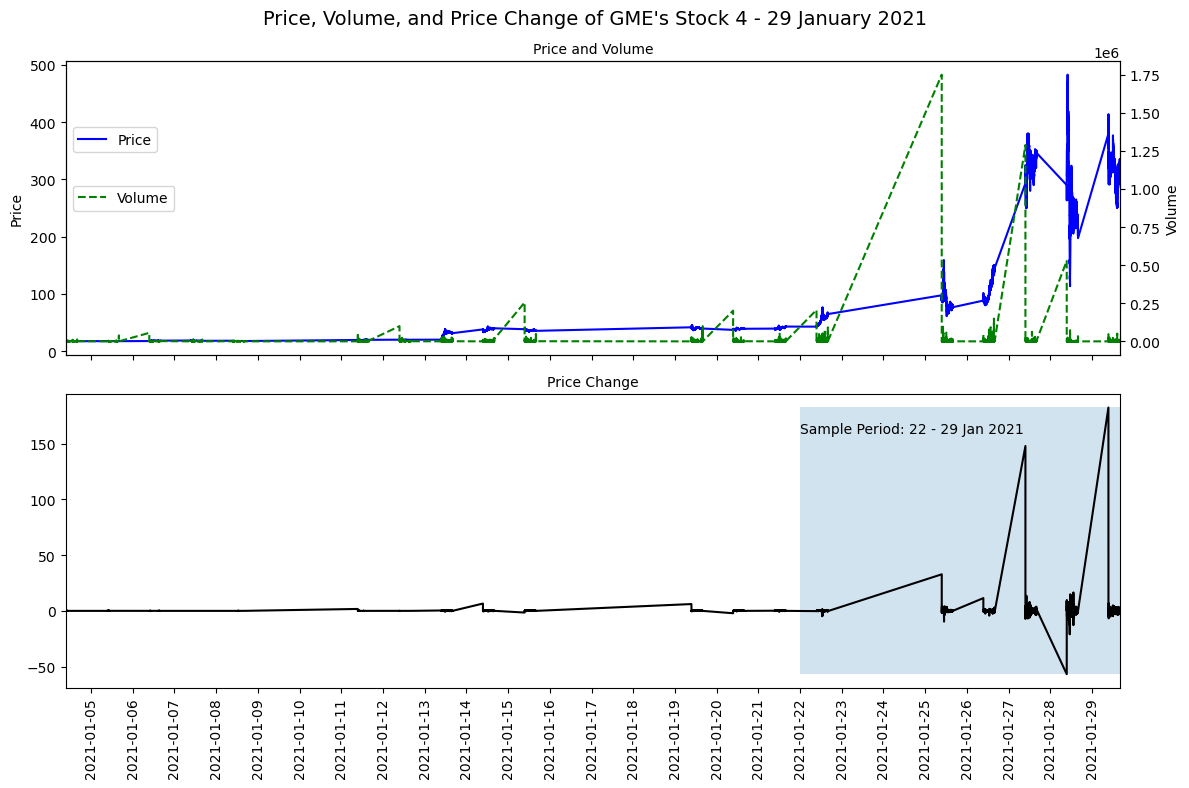

In [19]:
fig, (ax0, ax2) = plt.subplots(2, figsize = (12,8), sharex = True)

lowlim = min(trade.index)
hilim = max(trade.index)

# Chart: Price
ax0.plot(trade.index, trade['Price'], 'b-', label = 'Price')
plt.xticks(rotation = 90)

# Chart: Volume
ax1 = ax0.twinx()
ax1.plot(trade.index, trade['Volume'], 'g--', label = 'Volume')

# Chart: Price Change
x1 = pd.to_datetime('2021-01-22')

ax2.plot(trade.index, trade['Price_Change'], 'k-', label = 'Price Change')
ax2.fill_between([x1, max(trade.index)], [min(trade['Price_Change']), min(trade['Price_Change'])], [max(trade['Price_Change']), max(trade['Price_Change'])], alpha = 0.2)

# Ticks, Title, Labels, Annotation
ax2.annotate('Sample Period: 22 - 29 Jan 2021', xy = (x1, 160))

ax0.set_xlim([lowlim, hilim])
ax0.xaxis.set_major_locator(mdates.DayLocator())

ax0.set_ylabel('Price')
ax1.set_ylabel('Volume')
ax0.legend(loc = 'upper left', bbox_to_anchor  = (0., 0.8))
ax1.legend(loc = 'upper left', bbox_to_anchor  = (0., 0.6))

ax0.set_title('Price and Volume', fontsize = 10)
ax2.set_title('Price Change', fontsize = 10)

fig.suptitle('Price, Volume, and Price Change of GME\'s Stock 4 - 29 January 2021', fontsize = 14)
plt.tight_layout()
plt.savefig('charts_csv_report/gme.png', format = 'png')

plt.show()

## Major Slicing for Price Change Pivot Tables

In [20]:
# Use this for intraday zooming-in

# Upwards pattern
trade_22_27 = trade[(trade.index.day >= 22) & (trade.index.day <= 27)]
display(trade_22_27)

# Downwards pattern
trade_28_29 = trade[(trade.index.day >= 28)]
display(trade_28_29)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,
2021-01-22 09:30:01.495642146,Trade,42.79,206272.0,43.01,24.0,43.03,619.0,v,2021-01-22,-1.0,09:30:01.495642,Large,10000+,43.02,-0.23,0.23
2021-01-22 09:30:01.495642146,Trade,42.79,0.0,43.01,24.0,43.03,619.0,NaN,2021-01-22,NaN,09:30:01.495642,Micro,<200,42.79,0.00,0.00
2021-01-22 09:30:01.507546960,Trade,42.78,15.0,42.76,1.0,42.81,10.0,NaN,2021-01-22,NaN,09:30:01.507546,Micro,<200,42.79,-0.01,0.01
2021-01-22 09:30:01.507546960,Trade,42.77,18.0,42.76,1.0,42.81,10.0,NaN,2021-01-22,NaN,09:30:01.507546,Micro,<200,42.78,-0.01,0.01
2021-01-22 09:30:01.507546960,Trade,42.76,1.0,42.76,1.0,42.81,10.0,NaN,2021-01-22,NaN,09:30:01.507546,Micro,<200,42.77,-0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27 15:59:59.880443607,Trade,345.00,97.0,345.00,4.0,347.02,1.0,NaN,2021-01-27,NaN,15:59:59.880443,Micro,<200,346.65,-1.65,1.65
2021-01-27 15:59:59.884220244,Trade,345.00,16.0,345.00,2.0,347.02,1.0,NaN,2021-01-27,NaN,15:59:59.884220,Micro,<200,345.00,0.00,0.00
2021-01-27 15:59:59.884220244,Trade,345.00,1.0,345.00,2.0,347.02,1.0,NaN,2021-01-27,NaN,15:59:59.884220,Micro,<200,345.00,0.00,0.00


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,
2021-01-28 09:30:28.291493819,Trade,289.99,528491.0,345.0,2.0,346.82,6.0,v,2021-01-28,-1.0,09:30:28.291493,Large,10000+,346.84,-56.85,56.85
2021-01-28 09:30:28.291493819,Trade,289.99,0.0,345.0,2.0,346.82,6.0,NaN,2021-01-28,NaN,09:30:28.291493,Micro,<200,289.99,0.00,0.00
2021-01-28 09:30:28.376170108,Trade,289.67,1.0,288.0,1.0,290.00,10.0,NaN,2021-01-28,NaN,09:30:28.376170,Micro,<200,289.99,-0.32,0.32
2021-01-28 09:30:28.384200820,Trade,289.67,9.0,287.7,1.0,290.00,10.0,NaN,2021-01-28,NaN,09:30:28.384200,Micro,<200,289.67,0.00,0.00
2021-01-28 09:30:28.395520961,Trade,289.33,3.0,287.7,1.0,290.00,10.0,NaN,2021-01-28,NaN,09:30:28.395520,Micro,<200,289.67,-0.34,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:59.875667000,Trade,328.00,15.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.875667,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.887567967,Trade,328.00,10.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.887567,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.936339122,Trade,328.00,1.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.936339,Micro,<200,328.00,0.00,0.00


## Export: Pivot of Trade Categories

In [21]:
glob_pc = piv_cumprice(trade)
glob_pc.to_csv('charts_csv_report/pivot_cat_result.csv')
display(type(glob_pc))

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299             -80.822          -26.16       55447   
              300-399             -14.720           -4.76       24195   
              400-499             -34.432          -11.14       12974   
Micro         <200                339.952          110.02     1251069   
Medium        1000-2999           -13.405           -4.34        9761   
              3000-5999             2.904            0.94        1571   
              500-999             -21.077           -6.82       22078   
              6000-9999             6.050            1.96         426   
Large         10000+              124.540           40.31         338   
All                               308.990          100.01     1377859   

                             % Trade       Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                                  
Small         200-299           4.02   12008567.0      9.66  
              300-399           1.76    7741896.0      6.23  
              400-499           0.94    5487387.0      4.41  
Micro         <200             90.80   48726265.0     39.20  
Medium        1000-2999         0.71   15007505.0     12.07  
              3000-5999         0.11    6393466.0      5.14  
              500-999           1.60   14319734.0     11.52  
              6000-9999         0.03    3263107.0      2.63  
Large         10000+            0.02   11356370.0      9.14  
All                            99.99  124304297.0    100.00

pandas.core.frame.DataFrame

In [22]:
upward_pc = piv_cumprice(trade_22_27)
upward_pc.to_csv('charts_csv_report/pivot_cat_upward.csv')
display(type(upward_pc))

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299             -40.718          -13.40       29038   
              300-399             -11.644           -3.83       13216   
              400-499             -18.387           -6.05        7221   
Micro         <200                225.647           74.27      655180   
Medium        1000-2999            -8.976           -2.95        5155   
              3000-5999            -6.125           -2.02         865   
              500-999             -21.027           -6.92       11807   
              6000-9999             2.880            0.95         229   
Large         10000+              182.170           59.96         179   
All                               303.820          100.01      722890   

                             % Trade      Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                                 
Small         200-299           4.02   6335080.0      9.15  
              300-399           1.83   4238896.0      6.12  
              400-499           1.00   3061646.0      4.42  
Micro         <200             90.63  27473785.0     39.66  
Medium        1000-2999         0.71   7935537.0     11.46  
              3000-5999         0.12   3525733.0      5.09  
              500-999           1.63   7649897.0     11.04  
              6000-9999         0.03   1746602.0      2.52  
Large         10000+            0.02   7299645.0     10.54  
All                            99.99  69266821.0    100.00

pandas.core.frame.DataFrame

In [23]:
downward_pc = piv_cumprice(trade_28_29)
downward_pc.to_csv('charts_csv_report/pivot_cat_downward.csv')
display(type(downward_pc))

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299             -37.945          201.41        4111   
              300-399               1.565           -8.31        1604   
              400-499             -12.545           66.59         854   
Micro         <200                 81.700         -433.65      409840   
Medium        1000-2999            -7.935           42.12         609   
              3000-5999             7.630          -40.50         134   
              500-999              -0.540            2.87        1448   
              6000-9999             3.000          -15.92          47   
Large         10000+              -53.770          285.40          36   
All                               -18.840          100.01      418683   

                             % Trade      Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                                 
Small         200-299           0.98    929900.0      6.79  
              300-399           0.38    536146.0      3.91  
              400-499           0.20    371729.0      2.71  
Micro         <200             97.89   7767379.0     56.68  
Medium        1000-2999         0.15    960192.0      7.01  
              3000-5999         0.03    559775.0      4.08  
              500-999           0.35    954820.0      6.97  
              6000-9999         0.01    363230.0      2.65  
Large         10000+            0.01   1260203.0      9.20  
All                           100.00  13703374.0    100.00

pandas.core.frame.DataFrame

## Export: Welch's ANOVA for 4 trade-sizes

In [24]:
# Test Variances between Samples using Levene

# Part A
micro_dependent = trade[trade['Trade_Size_L1'] == 'Micro']['Price_Change']
small_dependent = trade[trade['Trade_Size_L1'] == 'Small']['Price_Change']
med_dependent = trade[trade['Trade_Size_L1'] == 'Medium']['Price_Change']
large_dependent = trade[trade['Trade_Size_L1'] == 'Large']['Price_Change']
print(micro_dependent.shape)
print(small_dependent.shape)
print(med_dependent.shape)
print(large_dependent.shape)

stat, p = levene(micro_dependent, small_dependent, med_dependent, large_dependent, center = 'median')
display(stat, p)
print(f'p < 0.05', p < 0.05)
print(f'p-value = {p}, which means statistically significant --> populations don\'t have equal variances.')

# Part B
micro_dependent_f = trade_22_27[trade_22_27['Trade_Size_L1'] == 'Micro']['Price_Change']
small_dependent_f = trade_22_27[trade_22_27['Trade_Size_L1'] == 'Small']['Price_Change']
med_dependent_f = trade_22_27[trade_22_27['Trade_Size_L1'] == 'Medium']['Price_Change']
large_dependent_f = trade_22_27[trade_22_27['Trade_Size_L1'] == 'Large']['Price_Change']
print(micro_dependent_f.shape)
print(small_dependent_f.shape)
print(med_dependent_f.shape)
print(large_dependent_f.shape)

statf, pf = levene(micro_dependent_f, small_dependent_f, med_dependent_f, large_dependent_f, center = 'median')
display(statf, pf)
print(f'p < 0.05', pf < 0.05)
print(f'p-value = {pf}, which means statistically significant --> populations don\'t have equal variances.')

(1251069,)
(92616,)
(33836,)
(338,)


2085.7271395861935

0.0

p < 0.05 True
p-value = 0.0, which means statistically significant --> populations don't have equal variances.
(655180,)
(49475,)
(18056,)
(179,)


1284.2985584527873

0.0

p < 0.05 True
p-value = 0.0, which means statistically significant --> populations don't have equal variances.


In [25]:
# Perform Welch's test between Micro and the other groups

# Part A
tstat1, pval1 = stats.ttest_ind(micro_dependent, small_dependent, equal_var = False)
tstat2, pval2 = stats.ttest_ind(micro_dependent, med_dependent, equal_var = False)
tstat3, pval3 = stats.ttest_ind(micro_dependent, large_dependent, equal_var = False)
tstatval = [tstat1, tstat2, tstat3]
pvalval = [pval1, pval2, pval3]
index_cat = ['Micro-Small', 'Micro-Medium', 'Micro-Large']

welch_tab = pd.DataFrame({'t-statistic':tstatval, 'p-value': pvalval}, index = index_cat)
display(welch_tab)
welch_tab.to_csv('charts_csv_report/welch_tab.csv')

# Part B
tstat1f, pval1f = stats.ttest_ind(micro_dependent_f, small_dependent_f, equal_var = False)
tstat2f, pval2f = stats.ttest_ind(micro_dependent_f, med_dependent_f, equal_var = False)
tstat3f, pval3f = stats.ttest_ind(micro_dependent_f, large_dependent_f, equal_var = False)
tstatvalf = [tstat1f, tstat2f, tstat3f]
pvalvalf = [pval1f, pval2f, pval3f]
index_catf = ['Micro-Small', 'Micro-Medium', 'Micro-Large']

welch_tabf = pd.DataFrame({'t-statistic':tstatvalf, 'p-value': pvalvalf}, index = index_catf)
display(welch_tabf)
welch_tabf.to_csv('charts_csv_report/welch_tabf.csv')

,t-statistic,p-value
Micro-Small,2.986812,0.002819
Micro-Medium,1.307163,0.191163
Micro-Large,-0.768023,0.443011


,t-statistic,p-value
Micro-Small,2.897180,0.003766
Micro-Medium,2.355545,0.018504
Micro-Large,-1.202776,0.230660


In [26]:
# Perform Welch's ANOVA to compare the means of the 4 trade groups

# Part A
aov = pg.welch_anova(dv = 'Price_Change', between = 'Trade_Size_L1', data = trade)


display(aov)
aov.to_csv('charts_csv_report/aov.csv')

# Part B
aovf = pg.welch_anova(dv = 'Price_Change', between = 'Trade_Size_L1', data = trade_22_27)

display(aovf)
aovf.to_csv('charts_csv_report/aovf.csv') 

,Source,ddof1,ddof2,F,p-unc,np2
0,Trade_Size_L1,3,1669.196835,3.282498,0.020146,0.000231


,Source,ddof1,ddof2,F,p-unc,np2
0,Trade_Size_L1,3,880.504505,4.564537,0.00351,0.003185


In [27]:
# Performing Games-Howell post-hoc

gh = pg.pairwise_gameshowell(dv = 'Price_Change', between = 'Trade_Size_L1', data = trade_22_27)
gh.to_csv('charts_csv_report/gh.csv')
display(gh)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Large,Medium,1.017709,-0.001841,1.019551,0.845848,1.205360,178.000389,0.624261,0.906732
1,Large,Micro,1.017709,0.000344,1.017365,0.845847,1.202776,178.000040,0.625894,3.447141
2,Large,Small,1.017709,-0.001430,1.019139,0.845848,1.204874,178.000147,0.624568,1.480779
3,Medium,Micro,-0.001841,0.000344,-0.002186,0.000928,-2.355545,21929.728058,0.085897,-0.009650
4,Medium,Small,-0.001841,-0.001430,-0.000411,0.001038,-0.396517,32582.283035,0.978882,-0.003420
5,Micro,Small,0.000344,-0.001430,0.001774,0.000612,2.897180,79427.852578,0.019705,0.007960


# 5-sec Dataframe for Simple PI, Spread

For calculating simple price impact and spread, the data must be resampled in 5s interval as per literature.
Taking the sample period of **22 - 27 January 2021** for the regression.

## Resample 5-s: df = trade_sample

In [28]:
trade_22_27.info()
trade_sample = trade_22_27.copy(deep = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 722890 entries, 2021-01-22 09:30:01.495642146 to 2021-01-27 15:59:59.980891430
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Type                722890 non-null  object 
 1   Price               722890 non-null  float64
 2   Volume              722890 non-null  float64
 3   Bid Price           722890 non-null  float64
 4   Bid Size            722890 non-null  float64
 5   Ask Price           722890 non-null  float64
 6   Ask Size            722890 non-null  float64
 7   Tick Dir.           206223 non-null  object 
 8   Date                722890 non-null  object 
 9   num_tick_direction  206223 non-null  float64
 10  Exchange_Time_copy  722890 non-null  object 
 11  Trade_Size_L1       722890 non-null  object 
 12  Trade_Size_L2       722890 non-null  object 
 13  Prev_Price          722890 non-null  float64
 14  Price_Change        722890 non

In [29]:
# Start Fresh with Trade Sample --> 22 - 27 Jan 2021

# Loop the df name
dates = np.unique(trade_sample.index.day)

# 5-s INTERVAL
# ================
dfname_list_5s = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_5s.append(dfname)
print(dfname_list_5s)

# Resample each date's df
           
for i in range(len(dfname_list_5s)):
    
    df = trade_sample[trade_sample.index.day == dates[i]]
    
    dfname_list_5s[i] = df.resample('5S').last().ffill()
    dfname_list_5s[i] = trade_cat(dfname_list_5s[i])
    dfname_list_5s[i] = mqr_prc_c(dfname_list_5s[i])
    dfname_list_5s[i] = simple_pi_spread(dfname_list_5s[i])
    
    # Dropping the 1st and last row
    dfname_list_5s[i] = dfname_list_5s[i].iloc[1:-1, :]

# Concatenate

trade_5_s = pd.DataFrame()

for i in range(len(dfname_list_5s)):
    trade_5_s = pd.concat([trade_5_s, dfname_list_5s[i]])

display(trade_5_s)
print(trade_5_s.shape)


['df_22', 'df_25', 'df_26', 'df_27']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,TickSB,Simple_PI,Eff_Spread,Realised_Spread
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-22 09:30:05,Trade,42.970,25.0,42.77,1.0,43.00,34.0,^,2021-01-22,1.0,...,-0.130,0.130,42.885,42.975,43.030,-0.002094,1.0,0.006762,0.003964,-0.002798
2021-01-22 09:30:10,Trade,43.055,60.0,42.96,1.0,43.10,11.0,^,2021-01-22,1.0,...,0.085,0.085,43.030,42.885,43.205,0.003381,1.0,0.008134,0.001162,-0.006972
2021-01-22 09:30:15,Trade,43.260,1.0,43.11,1.0,43.30,2.0,^,2021-01-22,1.0,...,0.205,0.205,43.205,43.030,43.675,0.004067,1.0,0.021757,0.002546,-0.019211
2021-01-22 09:30:20,Trade,43.760,5.0,43.52,1.0,43.83,6.0,^,2021-01-22,1.0,...,0.500,0.500,43.675,43.205,43.545,0.010878,1.0,-0.005953,0.003892,0.009845
2021-01-22 09:30:25,Trade,43.545,100.0,43.36,1.0,43.73,6.0,v,2021-01-22,-1.0,...,-0.215,0.215,43.545,43.675,43.635,-0.002977,-1.0,-0.004134,-0.000000,0.004134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27 15:59:30,Trade,348.550,6.0,348.05,1.0,348.57,1.0,v,2021-01-27,-1.0,...,-1.300,1.300,348.310,349.850,348.150,-0.004402,1.0,-0.000919,0.001378,0.002297
2021-01-27 15:59:35,Trade,348.250,100.0,347.73,1.0,348.57,3.0,^,2021-01-27,1.0,...,-0.300,0.300,348.150,348.310,346.950,-0.000459,1.0,-0.006894,0.000574,0.007468
2021-01-27 15:59:40,Trade,347.500,1.0,346.40,5.0,347.50,1.0,v,2021-01-27,-1.0,...,-0.750,0.750,346.950,348.150,349.630,-0.003447,1.0,0.015449,0.003170,-0.012278


(18495, 24)


In [30]:
# Checking if there's any NaN value

trade_5_s.isna().sum()

Type                  0
Price                 0
Volume                0
Bid Price             0
Bid Size              0
Ask Price             0
Ask Size              0
Tick Dir.             0
Date                  0
num_tick_direction    0
Exchange_Time_copy    0
Trade_Size_L1         0
Trade_Size_L2         0
Prev_Price            0
Price_Change          0
Price_Change_Abs      0
Mid_Quote             0
Prev_Mid_Quote        0
Next_Mid_Quote        0
Mid_Quote_Return      0
TickSB                0
Simple_PI             0
Eff_Spread            0
Realised_Spread       0
dtype: int64

In [31]:
# Checking the 1st row logic

display(trade_5_s[trade_5_s.index.day == 26][['Prev_Price', 'Price_Change', 'Simple_PI']])
# Proof that the 1st row Price Change is != 0 because 1st row already dropped

,Prev_Price,Price_Change,Simple_PI
Date-Time,,,
2021-01-26 09:30:35,90.00,0.58,0.024402
2021-01-26 09:30:40,90.58,1.14,0.017236
2021-01-26 09:30:45,91.72,1.08,0.038936
2021-01-26 09:30:50,92.80,1.68,0.027371
2021-01-26 09:30:55,94.48,1.37,0.024280
...,...,...,...
2021-01-26 15:59:30,143.83,0.79,0.003944
2021-01-26 15:59:35,144.62,0.36,0.000483
2021-01-26 15:59:40,144.98,-0.09,-0.014637


In [32]:
# Checking the ticks values

display(trade_5_s['TickSB'].value_counts())
display(trade_5_s['TickSB'].isna().sum())

 1.0    9638
-1.0    8857
Name: TickSB, dtype: int64

0

In [33]:
trade_5_s.describe()

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,TickSB,Simple_PI,Eff_Spread,Realised_Spread
count,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000
mean,142.266512,81.476669,141.841845,5.506029,142.697899,14.793620,-0.035307,142.260963,0.005549,0.540082,142.269872,142.264345,142.275348,0.000063,0.042228,0.001866,0.002585,0.000719
std,107.355003,264.879124,106.956636,23.027019,107.763176,68.349383,0.999404,107.352471,1.070878,0.924720,107.359180,107.356722,107.361568,0.005889,0.999135,0.011628,0.002843,0.011496
min,42.560000,1.000000,42.470000,1.000000,42.670000,1.000000,-1.000000,42.560000,-15.010000,0.000000,42.575000,42.575000,42.575000,-0.105329,-1.000000,-0.210658,0.000000,-0.217177
25%,69.500000,8.000000,69.490000,1.000000,69.510000,1.000000,-1.000000,69.500000,-0.200000,0.060000,69.495000,69.495000,69.495000,-0.001593,-1.000000,-0.001783,0.000678,-0.002700
50%,89.630000,33.000000,89.410000,1.000000,89.880000,1.000000,-1.000000,89.630000,0.000000,0.220000,89.625000,89.625000,89.625000,0.000000,1.000000,0.000362,0.001774,0.000676
75%,148.750000,100.000000,148.570000,3.000000,148.980000,4.000000,1.000000,148.750000,0.240000,0.620000,148.760000,148.760000,148.760000,0.001930,1.000000,0.005212,0.003427,0.004502
max,379.850000,25043.000000,379.260000,989.000000,380.000000,4106.000000,1.000000,379.850000,12.770000,15.010000,379.630000,379.630000,379.630000,0.108645,1.000000,0.217290,0.035088,0.210960


In [34]:
trade_5_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18495 entries, 2021-01-22 09:30:05 to 2021-01-27 15:59:50
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                18495 non-null  object 
 1   Price               18495 non-null  float64
 2   Volume              18495 non-null  float64
 3   Bid Price           18495 non-null  float64
 4   Bid Size            18495 non-null  float64
 5   Ask Price           18495 non-null  float64
 6   Ask Size            18495 non-null  float64
 7   Tick Dir.           18495 non-null  object 
 8   Date                18495 non-null  object 
 9   num_tick_direction  18495 non-null  float64
 10  Exchange_Time_copy  18495 non-null  object 
 11  Trade_Size_L1       18495 non-null  object 
 12  Trade_Size_L2       18495 non-null  object 
 13  Prev_Price          18495 non-null  float64
 14  Price_Change        18495 non-null  float64
 15  Price_Change_Abs  

## Add Lagged Price Change Variable

In [35]:
# Lagged Price as per literature

trade_5_s['Price_Change_lag'] = trade_5_s['Price_Change'].shift(1).fillna(0)
display(trade_5_s.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18495 entries, 2021-01-22 09:30:05 to 2021-01-27 15:59:50
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                18495 non-null  object 
 1   Price               18495 non-null  float64
 2   Volume              18495 non-null  float64
 3   Bid Price           18495 non-null  float64
 4   Bid Size            18495 non-null  float64
 5   Ask Price           18495 non-null  float64
 6   Ask Size            18495 non-null  float64
 7   Tick Dir.           18495 non-null  object 
 8   Date                18495 non-null  object 
 9   num_tick_direction  18495 non-null  float64
 10  Exchange_Time_copy  18495 non-null  object 
 11  Trade_Size_L1       18495 non-null  object 
 12  Trade_Size_L2       18495 non-null  object 
 13  Prev_Price          18495 non-null  float64
 14  Price_Change        18495 non-null  float64
 15  Price_Change_Abs  

None

## Export: Correlation Matrix

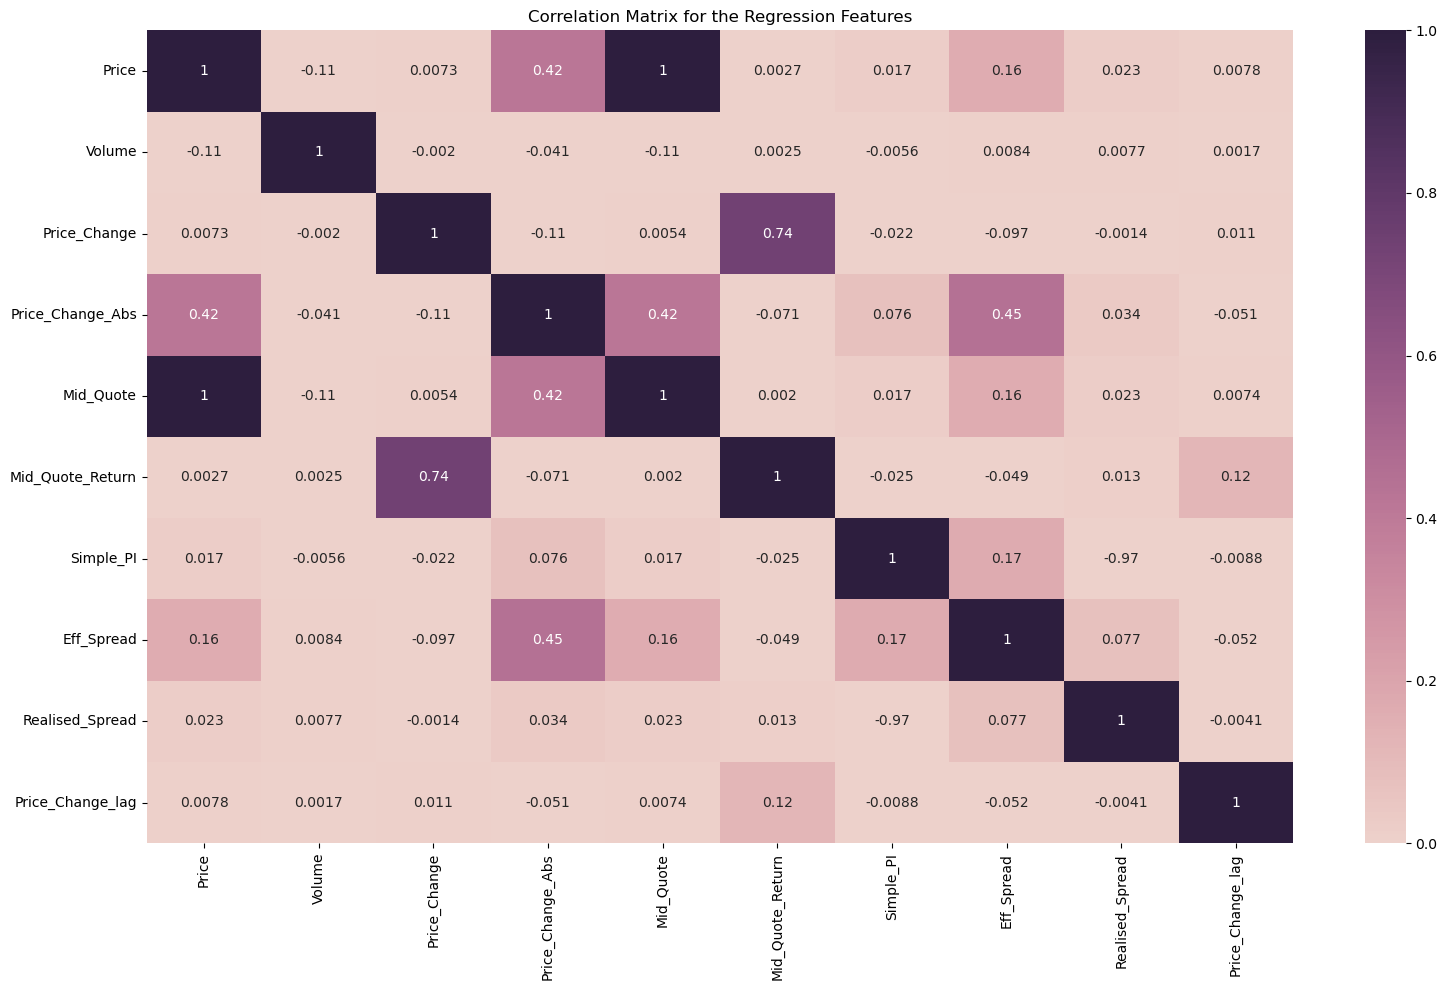

In [36]:
# Correlation Matrix

trade_5_s_reg = trade_5_s.drop(columns = ['Type', 'Bid Price', 'Bid Size', 'Ask Price', 'Ask Size',
                                     'Tick Dir.','Date','num_tick_direction','Exchange_Time_copy','Trade_Size_L2',
                                      'Prev_Price','Prev_Mid_Quote','Next_Mid_Quote','TickSB' 
                                     ]).copy(deep = True)

corr_mat = np.round(trade_5_s_reg.corr(), 5)

plt.figure(figsize = (16,10))
sns.heatmap(corr_mat, vmin = 0., vmax = 1., cmap = sns.cubehelix_palette(as_cmap = True), annot = True)


plt.title('Correlation Matrix for the Regression Features', fontsize = 12)
plt.tight_layout()
plt.savefig('charts_csv_report/corr_mat.png', format = 'png')
plt.show()


# Regression for trade_sample

**Remember** that:

`trade_22_27` --> `trade_sample` --> `trade_5_s` --> `trade_5_s_reg`

so we're doing the regression for **22-27 January 2021** period

## Spearman Correlation Test for Regression PI vs PC

In [37]:
# Perform Spearman rank test to compare Trade_L1 with Price Impact and Price Change --> only PI is significant

coef_pi, p_pi = spearmanr(trade_5_s_reg['Trade_Size_L1'], trade_5_s_reg['Simple_PI'])

coef_pc, p_pc = spearmanr(trade_5_s_reg['Trade_Size_L1'], trade_5_s_reg['Price_Change'])

print(f'Spearman\'s rank corr coefficient for Simple PI:{coef_pi} and p-val:{p_pi}')
print(f'Spearman\'s rank corr coefficient for PC:{coef_pc} and p-val:{p_pc}')

Spearman's rank corr coefficient for Simple PI:0.016179902101918754 and p-val:0.02777835053466432
Spearman's rank corr coefficient for PC:0.00482286084310331 and p-val:0.5119201097735356


## Export: Boxplot for Each L1 vs PI and PC

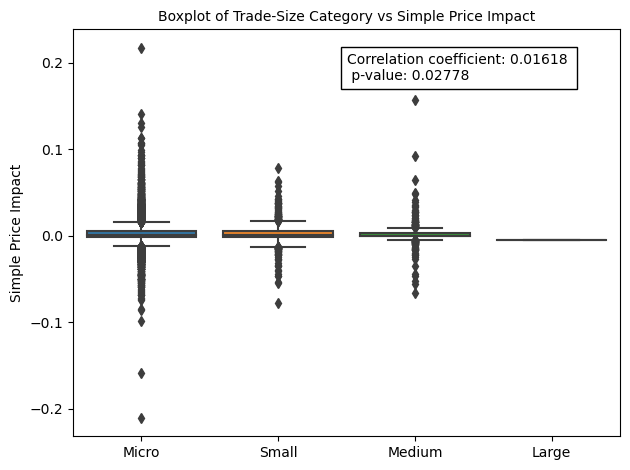

In [38]:
# for PI
plt.figure()
sns.boxplot(data = trade_5_s_reg, y = 'Simple_PI', x = 'Trade_Size_L1')

plt.text(1.5, 0.18, f'Correlation coefficient: {np.round(coef_pi, 5)} \n p-value: {np.round(p_pi, 5)}', fontsize = 10, bbox = dict(fc = 'none', ec = 'k', lw = 1))
plt.ylabel('Simple Price Impact')
plt.xlabel(None)
plt.title('Boxplot of Trade-Size Category vs Simple Price Impact', fontsize = 10)

plt.tight_layout()
plt.savefig('charts_csv_report/boxplot_pi.png')
plt.show()

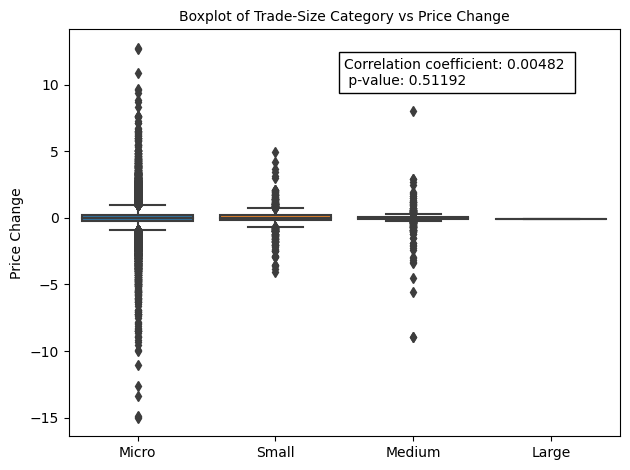

In [39]:
# for PC
plt.figure()
sns.boxplot(data = trade_5_s_reg, y = 'Price_Change', x = 'Trade_Size_L1')

plt.text(1.5, 10, f'Correlation coefficient: {np.round(coef_pc, 5)} \n p-value: {np.round(p_pc, 5)}', fontsize = 10, bbox = dict(fc = 'none', ec = 'k', lw = 1))
plt.title('Boxplot of Trade-Size Category vs Price Change', fontsize = 10)
plt.ylabel('Price Change')
plt.xlabel(None)
plt.tight_layout()
plt.savefig('charts_csv_report/boxplot_pc.png')
plt.show()

In [40]:
# One-hot Encoding
X_dummies = pd.get_dummies(trade_5_s['Trade_Size_L1'])
X_dummies = X_dummies.reindex(columns = ['Micro', 'Small', 'Medium', 'Large'])

display(X_dummies.head(5))
display(trade_5_s['Trade_Size_L1'].head(5))

display(trade_5_s_reg.info())

,Micro,Small,Medium,Large
Date-Time,,,,
2021-01-22 09:30:05,1,0,0,0
2021-01-22 09:30:10,1,0,0,0
2021-01-22 09:30:15,1,0,0,0
2021-01-22 09:30:20,1,0,0,0
2021-01-22 09:30:25,1,0,0,0


Date-Time
2021-01-22 09:30:05    Micro
2021-01-22 09:30:10    Micro
2021-01-22 09:30:15    Micro
2021-01-22 09:30:20    Micro
2021-01-22 09:30:25    Micro
Name: Trade_Size_L1, dtype: object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18495 entries, 2021-01-22 09:30:05 to 2021-01-27 15:59:50
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18495 non-null  float64
 1   Volume            18495 non-null  float64
 2   Trade_Size_L1     18495 non-null  object 
 3   Price_Change      18495 non-null  float64
 4   Price_Change_Abs  18495 non-null  float64
 5   Mid_Quote         18495 non-null  float64
 6   Mid_Quote_Return  18495 non-null  float64
 7   Simple_PI         18495 non-null  float64
 8   Eff_Spread        18495 non-null  float64
 9   Realised_Spread   18495 non-null  float64
 10  Price_Change_lag  18495 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB


None

## Excel: Regression y = Simple_PI

In [41]:
# Regression: y = Simple_PI

# Removing X_2 columns until R-squared makes sense 

y2 = trade_5_s_reg['Simple_PI']
X_2 = trade_5_s_reg[['Mid_Quote','Volume','Price_Change','Realised_Spread']]

# Price_Change_Abs worsens the p-value of each L1 Volume
# Volume,Realised_Spread, and Mid_Quote must be kept
# X_2 = trade_5_s_reg[['Price', 'Volume', 'Price_Change','Price_Change_Abs', 'Mid_Quote', 'Mid_Quote_Return','Realised_Spread','Price_Change_lag']]

X2 = pd.concat([X_dummies, X_2], axis = 1)

print(f'X shape: {X2.shape}, X columns = {X2.columns}')
print(f'y shape: {y2.shape}')

X shape: (18495, 8), X columns = Index(['Micro', 'Small', 'Medium', 'Large', 'Mid_Quote', 'Volume',
       'Price_Change', 'Realised_Spread'],
      dtype='object')
y shape: (18495,)


In [42]:
# Linear Regression 
X2 = sm.add_constant(X2)
linreg2 = sm.OLS(y2, X2)
results2 = linreg2.fit()
reg_out = results2.summary()
print(reg_out)

# Write the summary table to a text file
with open('charts_csv_report/regression_summary.txt', 'w') as f:
    f.write(reg_out.as_text())

                            OLS Regression Results                            
Dep. Variable:              Simple_PI   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 4.352e+04
Date:                Sat, 01 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:59:46   Log-Likelihood:                 82596.
No. Observations:               18495   AIC:                        -1.652e+05
Df Residuals:                   18487   BIC:                        -1.651e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0004      0.001     

# 1-min and 5-min Dataframes

For the variance ratio analysis, the sample period is **22 - 29 January 2021**.

## Identifying the new set 22_29

In [43]:
trade_22_29 = trade[(trade.index.day >= 22)].copy(deep = True)
display(trade_22_29)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,
2021-01-22 09:30:01.495642146,Trade,42.79,206272.0,43.01,24.0,43.03,619.0,v,2021-01-22,-1.0,09:30:01.495642,Large,10000+,43.02,-0.23,0.23
2021-01-22 09:30:01.495642146,Trade,42.79,0.0,43.01,24.0,43.03,619.0,NaN,2021-01-22,NaN,09:30:01.495642,Micro,<200,42.79,0.00,0.00
2021-01-22 09:30:01.507546960,Trade,42.78,15.0,42.76,1.0,42.81,10.0,NaN,2021-01-22,NaN,09:30:01.507546,Micro,<200,42.79,-0.01,0.01
2021-01-22 09:30:01.507546960,Trade,42.77,18.0,42.76,1.0,42.81,10.0,NaN,2021-01-22,NaN,09:30:01.507546,Micro,<200,42.78,-0.01,0.01
2021-01-22 09:30:01.507546960,Trade,42.76,1.0,42.76,1.0,42.81,10.0,NaN,2021-01-22,NaN,09:30:01.507546,Micro,<200,42.77,-0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:59.875667000,Trade,328.00,15.0,328.00,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.875667,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.887567967,Trade,328.00,10.0,328.00,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.887567,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.936339122,Trade,328.00,1.0,328.00,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.936339,Micro,<200,328.00,0.00,0.00


## Initial Descriptive

In [44]:
# Loop the df name
dates = np.unique(trade_22_29.index.day)

# A. 1-min INTERVAL
# ================
dfname_list_1min = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_1min.append(dfname)
print(dfname_list_1min)

# Resample each date's df
           
for i in range(len(dfname_list_1min)):
    
    df = trade_22_29[trade_22_29.index.day == dates[i]]
    
    dfname_list_1min[i] = df.resample('T').last().interpolate(method = 'linear')
    dfname_list_1min[i] = trade_cat(dfname_list_1min[i])
    dfname_list_1min[i] = mqr_prc_c(dfname_list_1min[i])
    
    # Dropping the 1st row because of 0
    dfname_list_1min[i] = dfname_list_1min[i].iloc[1:, :]
    
# Concatenate

trade_1_min = pd.DataFrame()

for i in range(len(dfname_list_1min)):
    trade_1_min = pd.concat([trade_1_min, dfname_list_1min[i]])

display(trade_1_min)
print(trade_1_min.shape)

# B. 5-min INTERVAL
# ================

dfname_list_5min = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_5min.append(dfname)
print(dfname_list_5min)

# Resample each date's df
           
for i in range(len(dfname_list_5min)):
    
    df = trade_22_29[trade_22_29.index.day == dates[i]]
    
    dfname_list_5min[i] = df.resample('5T').last().interpolate(method = 'linear')
    dfname_list_5min[i] = trade_cat(dfname_list_5min[i])
    dfname_list_5min[i] = mqr_prc_c(dfname_list_5min[i])
    dfname_list_5min[i] = dfname_list_5min[i].iloc[1:, :]
    
# Concatenate

trade_5_min = pd.DataFrame()

for i in range(len(dfname_list_5min)):
    trade_5_min = pd.concat([trade_5_min, dfname_list_5min[i]])

display(trade_5_min)
print(trade_5_min.shape)

['df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-22 09:31:00,Trade,42.73,100.0,42.72,1.0,42.93,1.0,v,2021-01-22,-1.0,09:31:59.431754,Micro,<200,43.37,-0.64,0.64,42.825,43.475,42.950,-0.014951
2021-01-22 09:32:00,Trade,42.94,6.0,42.90,2.0,43.00,171.0,^,2021-01-22,1.0,09:32:59.172069,Micro,<200,42.73,0.21,0.21,42.950,42.825,42.620,0.002919
2021-01-22 09:33:00,Trade,42.62,100.0,42.54,1.0,42.70,3.0,^,2021-01-22,1.0,09:33:57.808151,Micro,<200,42.94,-0.32,0.32,42.620,42.950,43.045,-0.007683
2021-01-22 09:34:00,Trade,43.00,96.0,42.96,3.0,43.13,1.0,^,2021-01-22,1.0,09:34:57.539430,Micro,<200,42.62,0.38,0.38,43.045,42.620,42.980,0.009972
2021-01-22 09:35:00,Trade,43.00,85.0,42.96,1.0,43.00,2.0,^,2021-01-22,1.0,09:35:59.971890,Micro,<200,43.00,0.00,0.00,42.980,43.045,43.025,-0.001510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:55:00,Trade,317.36,28.0,316.62,1.0,319.00,3.0,^,2021-01-29,1.0,15:55:59.675959,Micro,<200,325.74,-8.38,8.38,317.810,325.395,321.470,-0.023310
2021-01-29 15:56:00,Trade,321.00,1.0,320.95,2.0,321.99,2.0,^,2021-01-29,1.0,15:56:59.416251,Micro,<200,317.36,3.64,3.64,321.470,317.810,327.500,0.011516
2021-01-29 15:57:00,Trade,327.04,1.0,327.00,16.0,328.00,23.0,v,2021-01-29,-1.0,15:57:59.987839,Micro,<200,321.00,6.04,6.04,327.500,321.470,328.590,0.018758


(2318, 20)
['df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-22 09:35:00,Trade,44.12,763.0,44.00,5.0,44.12,6.0,^,2021-01-22,1.0,09:39:59.516358,Medium,500-999,43.00,1.12,1.12,44.060,43.045,43.945,0.023580
2021-01-22 09:40:00,Trade,43.96,42.0,43.90,1.0,43.99,1.0,^,2021-01-22,1.0,09:44:59.643371,Micro,<200,44.12,-0.16,0.16,43.945,44.060,44.610,-0.002610
2021-01-22 09:45:00,Trade,44.65,151.0,44.54,1.0,44.68,1.0,^,2021-01-22,1.0,09:49:58.712155,Micro,<200,43.96,0.69,0.69,44.610,43.945,45.685,0.015133
2021-01-22 09:50:00,Trade,45.66,100.0,45.60,1.0,45.77,2.0,v,2021-01-22,-1.0,09:54:58.560342,Micro,<200,44.65,1.01,1.01,45.685,44.610,45.925,0.024098
2021-01-22 09:55:00,Trade,45.97,100.0,45.85,1.0,46.00,41.0,^,2021-01-22,1.0,09:59:58.924377,Micro,<200,45.66,0.31,0.31,45.925,45.685,45.305,0.005253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:35:00,Trade,312.01,10.0,311.07,1.0,314.99,2.0,v,2021-01-29,-1.0,15:39:59.416133,Micro,<200,313.00,-0.99,0.99,313.030,313.000,319.215,0.000096
2021-01-29 15:40:00,Trade,319.23,30.0,318.53,1.0,319.90,4.0,^,2021-01-29,1.0,15:44:59.843839,Micro,<200,312.01,7.22,7.22,319.215,313.030,326.980,0.019758
2021-01-29 15:45:00,Trade,328.19,8.0,325.02,2.0,328.94,1.0,^,2021-01-29,1.0,15:49:59.880323,Micro,<200,319.23,8.96,8.96,326.980,319.215,325.395,0.024325


(460, 20)


In [45]:
# Test to check NaN after resampling

nullval = trade_5_min['Price'].isna().sum()

print(nullval)

display(trade_5_min[trade_5_min['Price'].isna()]) # --> fine because not in the numbers

0


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
Date-Time,,,,,,,,,,,,,,,,,,,,


## Variance Ratio

In [46]:
# Checking unique values because if there's only 1 entry, cannot calculate std - var

print('Trade_1_min unique value counts:\n', trade_1_min['Trade_Size_L1'].value_counts())
print('Trade_5_min unique value counts:\n', trade_5_min['Trade_Size_L1'].value_counts())

#--> from the result, exclude 'Large' from the variance ratio calc

Trade_1_min unique value counts:
 Micro     2131
Small      132
Medium      55
Name: Trade_Size_L1, dtype: int64
Trade_5_min unique value counts:
 Micro     418
Small      32
Medium     10
Name: Trade_Size_L1, dtype: int64


In [47]:
trade_1_min.describe()

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,191.957925,80.698231,191.199504,5.776531,192.767043,11.163287,-0.019845,191.987308,-0.029383,2.945336,191.983273,192.010389,191.459488,0.000346
std,116.807704,321.352672,116.299502,18.396590,117.377628,43.418364,0.988708,116.867074,5.304312,4.411104,116.836735,116.894917,117.054330,0.022647
min,42.620000,1.000000,42.540000,1.000000,42.700000,1.000000,-1.000000,42.620000,-42.290000,0.000000,42.620000,42.620000,0.000000,-0.167244
25%,81.346250,4.000000,80.970000,1.000000,81.457500,1.000000,-1.000000,81.388750,-1.250000,0.490000,81.241250,81.303750,80.506250,-0.008480
50%,147.935000,20.000000,147.725000,1.000000,148.100000,2.000000,-0.600000,147.935000,0.100000,1.415000,147.900000,147.900000,147.707500,0.000953
75%,316.000000,100.000000,315.000000,3.000000,317.754000,4.000000,1.000000,316.000000,1.540000,3.590000,316.311250,316.217500,316.217500,0.009840
max,468.890000,9290.000000,468.000000,222.000000,469.000000,745.000000,1.000000,468.890000,35.480000,42.290000,468.500000,468.500000,468.500000,0.189709


In [48]:
# Assigning variable names for variance ratio study

# Trade_1_min

trade_1_min_varrat_df = []
trade_5_min_varrat_df = []

for i in ['Micro','Small', 'Medium']:
    trade_1_min_varrat = piv_varrat(trade_1_min[trade_1_min['Trade_Size_L1'] == i].copy(deep = True))
    trade_1_min_varrat_df.append(trade_1_min_varrat)
    
    trade_5_min_varrat = piv_varrat(trade_5_min[trade_5_min['Trade_Size_L1'] == i].copy(deep = True))
    trade_5_min_varrat_df.append(trade_5_min_varrat)
    
# Test
display(trade_1_min_varrat_df[0])
display(trade_5_min_varrat_df[2])


,,STD_Log_MQR,Variance
,Trade_Size_L1,,
2021-01-22,Micro,0.503235,0.253245
2021-01-25,Micro,0.619898,0.384273
2021-01-26,Micro,0.587204,0.344808
2021-01-27,Micro,0.562099,0.315955
2021-01-28,Micro,0.568474,0.323163
2021-01-29,Micro,0.571343,0.326433


,,STD_Log_MQR,Variance
,Trade_Size_L1,,
2021-01-22,Medium,0.454682,0.206736


In [49]:
# Inner Join based on Trade L1 -- different size different list

inner_join_df = []

for i in range(len(trade_1_min_varrat_df)): # --> contains 3 df of micro, small, medium
    index0_ = trade_1_min_varrat_df[i].index.names[0]
    index1_ = trade_1_min_varrat_df[i].index.names[1]
    
    # Inner Join and Rename Columns 
    in_join = pd.merge(trade_1_min_varrat_df[i], trade_5_min_varrat_df[i], on = [index0_, index1_], how = 'inner').rename(columns = {'STD_Log_MQR_x':'STD_Log_MQR_1', 
                                                                                                                                     'Variance_x':'Var_of_Log_MQR_1',
                                               'STD_Log_MQR_y':'STD_Log_MQR_5', 'Variance_y':'Var_of_Log_MQR_5'
                                               })
    
    # Variance Ratio calculation
    in_join['Var_Rat'] = np.abs((in_join['Var_of_Log_MQR_5']/(5 * in_join['Var_of_Log_MQR_1'])) - 1)
    
    inner_join_df.append(in_join)  

# Test
display(max(inner_join_df[0]['Var_Rat']), min(inner_join_df[0]['Var_Rat']))
display(max(inner_join_df[1]['Var_Rat']), min(inner_join_df[1]['Var_Rat']))
display(max(inner_join_df[2]['Var_Rat']), min(inner_join_df[2]['Var_Rat']))
display(inner_join_df[2])



0.8320276828732249

0.7531822511412267

0.9467715121282799

0.6171786717002993

0.9037363686638848

0.9037363686638848

,key_0,STD_Log_MQR_1,Var_of_Log_MQR_1,STD_Log_MQR_5,Var_of_Log_MQR_5,Var_Rat
Trade_Size_L1,,,,,,
Medium,"(2021-01-22, Medium)",0.655378,0.42952,0.454682,0.206736,0.903736


## Export: Variance Ratio Chart

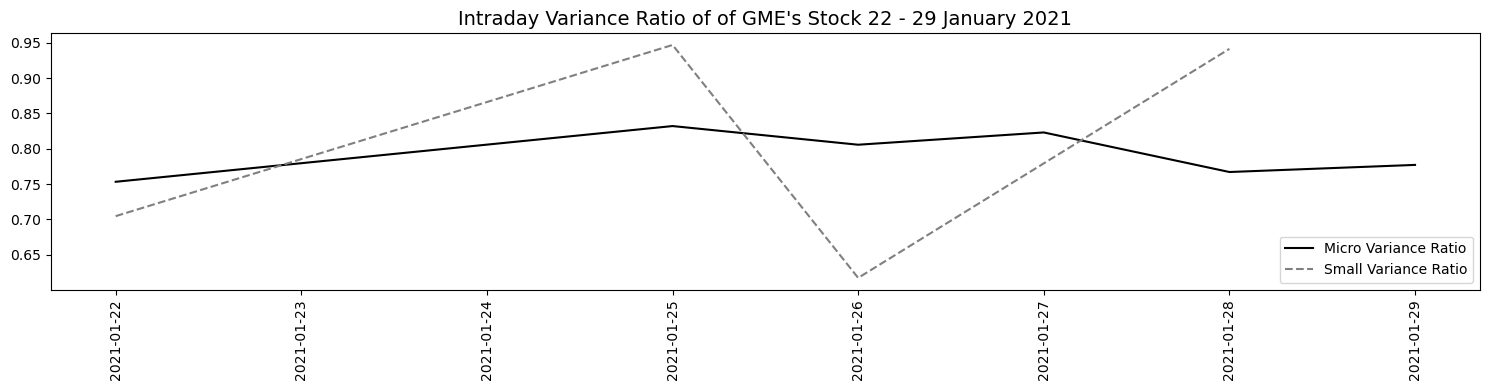

In [50]:
# Plotting the Variance Ratio among 3 trade sizes


# Index for plots Micro, Small, Medium

list_x_index = []

for i in inner_join_df:
    
    list_x = list(i['key_0'])
    index_date_ = []
    for j in list_x:
        date_a = j[0]
        index_date_.append(date_a)
    list_x_index.append(index_date_)


# Set x and y
index_mic = list_x_index[0]
index_s = list_x_index[1]
index_med = list_x_index[2]

min_idx = min(index_mic)
max_idx = max(index_mic)


var_rat_mic = inner_join_df[0]['Var_Rat']
var_rat_s = inner_join_df[1]['Var_Rat']
var_rat_med = inner_join_df[2]['Var_Rat']

# Plotting
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(index_mic, var_rat_mic, 'k-', label = 'Micro Variance Ratio')
ax.plot(index_s, var_rat_s, color = 'gray', ls = '--', label = 'Small Variance Ratio')

plt.xticks(rotation = 90)

ax.legend(loc = 'lower right')


# Ticks, Title, Labels

ax0.xaxis.set_major_locator(mdates.DayLocator())
ax0.set_ylabel('Variance Ratio')

plt.title('Intraday Variance Ratio of of GME\'s Stock 22 - 29 January 2021', fontsize = 14)

plt.tight_layout()
plt.savefig('charts_csv_report/gme_varrat.png', format = 'png')
plt.show()


#  1-min Liquidity vs Market Efficiency

Downsampling the 5-sec intervals to 1-min intervals to calculate OIB regression.
Use the manual summation instead of the resample method.

## Resample 5-sec

In [51]:
# 22 - 29 Jan 2021

# Loop the df name
dates = np.unique(trade_22_29.index.day)

# 5-s INTERVAL
# ================
dfname_list_5s = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_5s.append(dfname)
print(dfname_list_5s)

# Resample each date's df
           
for i in range(len(dfname_list_5s)):
    
    df = trade_22_29[trade_22_29.index.day == dates[i]]
    
    dfname_list_5s[i] = df.resample('5S').last().ffill()
    dfname_list_5s[i] = trade_cat(dfname_list_5s[i])
    dfname_list_5s[i] = mqr_prc_c(dfname_list_5s[i])
    dfname_list_5s[i] = simple_pi_spread(dfname_list_5s[i])
    
    # Dropping the 1st and last row 
    dfname_list_5s[i] = dfname_list_5s[i].iloc[1:-1, :]

# Concatenate

trade_5_s_22_29 = pd.DataFrame()

for i in range(len(dfname_list_5s)):
    trade_5_s_22_29 = pd.concat([trade_5_s_22_29, dfname_list_5s[i]])

# display(trade_5_s_22_29)
print(trade_5_s_22_29.shape)

['df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']
(27841, 24)


## Export: Plot Simple PI and ESPR

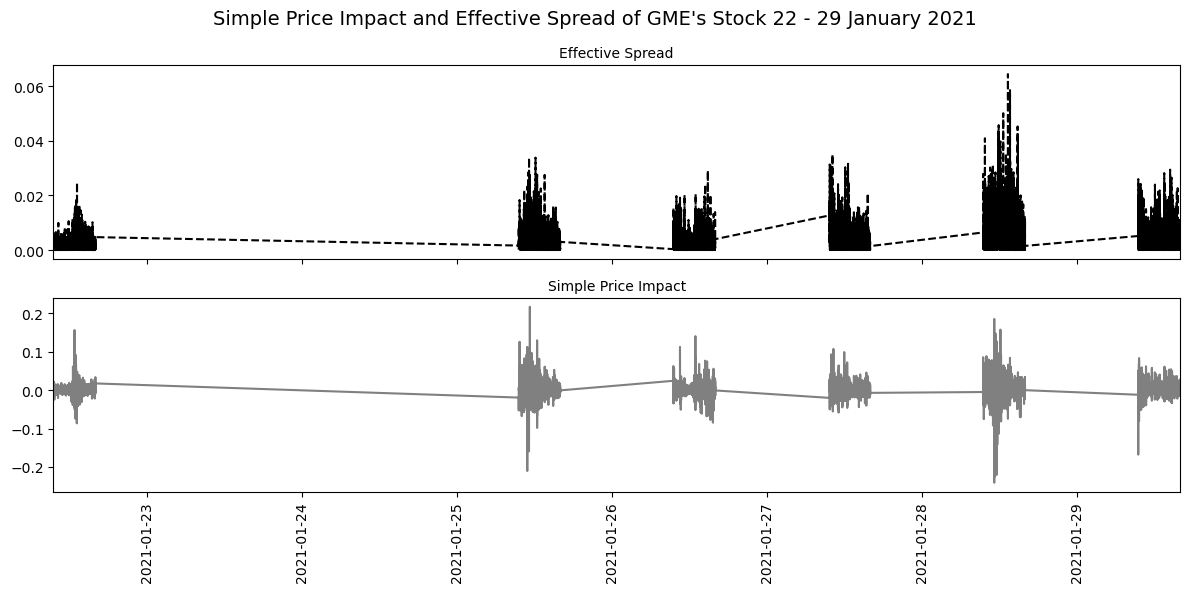

In [52]:
# Plot Simple PI vs Effective Spread

# Focus Sampling on 22 - 29 Jan 2021

fig, (ax0, ax1) = plt.subplots(2, figsize = (12,6), sharex = True)

lowlim = min(trade_5_s_22_29.index)
hilim = max(trade_5_s_22_29.index)

ax0.plot(trade_5_s_22_29.index, trade_5_s_22_29['Eff_Spread'], 'k--', label = 'Effective Spread')
ax1.plot(trade_5_s_22_29.index, trade_5_s_22_29['Simple_PI'], color = 'gray', ls = '-', label = 'Simple Price Impact')

plt.xticks(rotation = 90)

# Ticks, Title, Labels

ax0.set_xlim([lowlim, hilim])
ax0.xaxis.set_major_locator(mdates.DayLocator())

ax0.set_title('Effective Spread', fontsize = 10)
ax1.set_title('Simple Price Impact', fontsize = 10)

plt.suptitle('Simple Price Impact and Effective Spread of GME\'s Stock 22 - 29 January 2021', fontsize = 14)
plt.tight_layout()

plt.savefig('charts_csv_report/spreadpi.png', format = 'png')

plt.show()

# OIB-USD vs OIB-Trade Calc for the 1-min interval

**Remember**:

Data must be 5-sec then resampled in the custom function to be in 1-min interval.

`trade_22_29` --> `trade_5_s_22_29` 

so we're doing the OIB regression for **22-29 January 2021** period

In [53]:
dflist_test, date_index_test = oib_resample(trade_5_s_22_29)

## OIB-USD and Eff_Spread Statistics Summary

In [54]:
oib_stat_tab = oib_stat(dflist_test, date_index_test)
display(oib_stat_tab)
oib_stat_tab.to_csv('charts_csv_report/oib_stat.csv')

,OIB$ Mean,OIB$ Median,OIB$ std,OIB# Mean,OIB# Median,OIB# std,ESPR Mean,ESPR Median,ESPR std
2021-01-22,-0.108809,-0.131423,0.526503,-0.079409,-0.166667,0.404311,0.001656,0.001149,0.001842
2021-01-25,0.118676,0.089679,0.560450,0.129356,0.000000,0.439287,0.003107,0.002361,0.003388
2021-01-26,0.068309,0.057047,0.569227,0.048601,0.000000,0.426158,0.002236,0.001490,0.002820
2021-01-27,-0.002087,-0.023587,0.601548,0.078129,0.000000,0.409567,0.003369,0.002597,0.003103
2021-01-28,0.001837,0.039886,0.731543,0.070085,0.166667,0.603773,0.005198,0.003740,0.005994
2021-01-29,0.014189,0.036969,0.600265,0.034136,0.000000,0.394826,0.003814,0.002979,0.003561


## Run the OIB Regression 

In [55]:
rsq, rsqadj = oib_reg(dflist_test)

## Export: R-squared

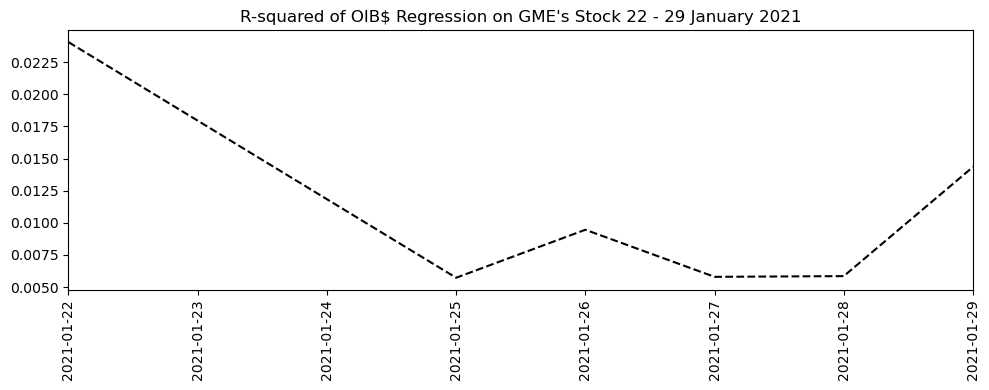

In [56]:
# Plot R-squared

# Focus Sampling on 22 - 29 Jan 2021

# Set axes
fig, ax = plt.subplots(figsize = (10,4))

lowlim = min(date_index_test)
hilim = max(date_index_test)

datespan = pd.date_range(start = lowlim, end = hilim, freq = 'D')
plot_x = datespan.delete([1, 2]) #--> deleting date 23 and 24 Jan as weekend

# Plot
ax.plot(plot_x, rsq, 'k--')

plt.xticks(rotation = 90)

# Ticks, Title, Labels

ax.set_xlim([lowlim, hilim])
ax.xaxis.set_major_locator(mdates.DayLocator())

plt.title('R-squared of OIB$ Regression on GME\'s Stock 22 - 29 January 2021', fontsize = 12)
plt.tight_layout()

plt.savefig('charts_csv_report/r_oib.png', format = 'png')

plt.show()